In [12]:
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np

#from torchvision.datasets import MNIST
from torch import nn
from torch.nn.modules import BatchNorm1d
import torch.nn.functional as F
from torch.autograd import Variable
import torch

%matplotlib inline

# MNIST Model

In [13]:
#mnist = MNIST('.', train=True, transform=None, target_transform=None, download=True)
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [14]:
class LayerNorm(nn.Module):

    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

In [15]:
# class CrossEntropy(torch.nn.Module):
    
#     def __init__(self):
#         super(CrossEntropy, self).__init__()
        
#     def forward(self, y_pred, y_true):      
#         y_ohe = Variable( torch.eye(10).index(y_true.data) )
        
#         return -torch.mean( torch.sum( y_ohe * torch.log(y_pred) + (1-y_ohe) * torch.log(1-y_pred) , 
#                               dim = 1, keepdim=False))

In [16]:
class Model(nn.Module):
    
    def __init__(self, 
                 model_type,):
        super(Model, self).__init__()
        self.model_type = model_type
        
        self.dl_1 = nn.Linear(784, 100)
        self.dl_2 = nn.Linear(100, 100)
        self.dl_3 = nn.Linear(100, 100)
        self.dl_4 = nn.Linear(100,10)
        
        if self.model_type == 'bn':
            self.n_1 = BatchNorm1d(784)
            self.n_2 = BatchNorm1d(100)
            self.n_3 = BatchNorm1d(100)
            self.n_4 = BatchNorm1d(100)
            
        if self.model_type == 'ln':
            self.n_1 = LayerNorm(784)
            self.n_2 = LayerNorm(100)
            self.n_3 = LayerNorm(100)
            self.n_4 = LayerNorm(100)
        
      #  self.loss_function = CrossEntropy()#torch.nn.BCELoss()
        
    def forward(self, x):
        if self.model_type == 'normal':
            x = F.relu(self.dl_1(x))
            x = F.relu(self.dl_2(x))
            x = F.relu(self.dl_3(x))
            x = F.softmax(self.dl_4(x), dim = 1)
        else:
            x = F.relu(self.dl_1(self.n_1(x)))
            x = F.relu(self.dl_2(self.n_2(x)))
            x = F.relu(self.dl_3(self.n_3(x)))
            x = F.softmax(self.dl_4(self.n_4(x)), dim = 1)
        return x
    
    def loss(self, y_pred, y_true):      
        y_ohe = Variable( torch.eye(10).index(y_true.data.cpu()).cuda() )
        
        return -torch.mean( torch.sum( y_ohe * torch.log(y_pred) , #+ (1-y_ohe) * torch.log(1-y_pred) , 
                              dim = 1, keepdim=False))

    def accuracy(self, y_pred, y_true):
        return torch.mean(torch.FloatTensor((torch.max(y_pred, 1)[1] == y_true).data.cpu().numpy()))
        

In [29]:
def training():
    acc_values = []
    time_stamps = []
    last_time=0
    optimiser = torch.optim.Adam(model.parameters())#,lr = 0.001)
    for i in tqdm(range(1000)):
        batch_xs, batch_ys = mnist.train.next_batch(128)
        batch_xs = Variable(torch.cuda.FloatTensor(batch_xs), requires_grad=True)
        batch_ys = Variable(torch.cuda.LongTensor(batch_ys))
        
        start_timer = time.time()
        loss = model.loss( model(batch_xs), batch_ys)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        stop_timer = time.time()

        x_test = Variable(torch.cuda.FloatTensor(mnist.test.images))
        y_test = Variable(torch.cuda.LongTensor(mnist.test.labels))
        acc_values.append(model.accuracy(model(x_test), y_test))
       
        last_time = last_time + (stop_timer - start_timer)
        time_stamps.append(last_time)
        #if i%10==0: print(float(loss))
    return time_stamps, acc_values

In [30]:
model = Model('normal').cuda()
time_stamps_simple, acc_values_simple = training()

model = Model('bn').cuda()
time_stamps_bn, acc_values_bn = training()

model = Model('ln').cuda()
time_stamps_ln, acc_values_ln = training()

100%|██████████| 1000/1000 [00:26<00:00, 37.92it/s]


In [31]:
accuracies = [0.6, 0.7, 0.8, 0.9]

def get_steps_and_time(acc_values, time_stamps, accuracy_threshold):
    steps = sum(np.array(acc_values) < accuracy_threshold)
    time = time_stamps[steps-1]
    return steps, time

endings = ['simple', 'ln', 'bn']

results_times = {}
results_steps = {}
for acc in accuracies:
    results_times[acc] = {}
    results_steps[acc] = {}
    for end in endings:
        step, time_spent = get_steps_and_time(eval('acc_values_'+end), eval('time_stamps_'+end), acc )
        results_times[acc][end] = time_spent
        results_steps[acc][end] = step

In [32]:
import pandas as pd
pd.DataFrame(results_times).T

,bn,ln,simple
0.6,0.014459,0.018021,0.045431
0.7,0.025562,0.027221,0.057212
0.8,0.053490,0.058607,0.095484
0.9,0.152221,0.197496,0.312856


In [33]:
pd.DataFrame(results_steps).T

,bn,ln,simple
0.6,5,4,22
0.7,9,6,28
0.8,19,13,47
0.9,54,44,156


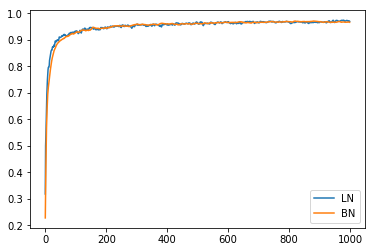

In [34]:
# Comparing moment functions in CPU and GPUplt.plot(acc_values_simple, label="Simple")
plt.plot(acc_values_ln, label='LN')
plt.plot(acc_values_bn, label='BN')
plt.legend()

(0, 150)

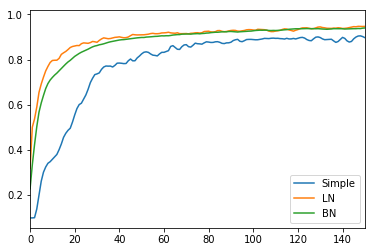

In [35]:
plt.plot(acc_values_simple, label="Simple")
plt.plot(acc_values_ln, label='LN')
plt.plot(acc_values_bn, label='BN')
plt.legend()
plt.xlim([0,150])

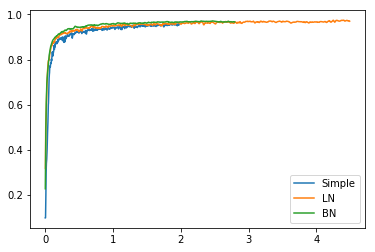

In [36]:
plt.plot(time_stamps_simple, acc_values_simple, label="Simple")
plt.plot(time_stamps_ln, acc_values_ln, label='LN')
plt.plot(time_stamps_bn, acc_values_bn, label='BN')
plt.legend()

(0, 1)

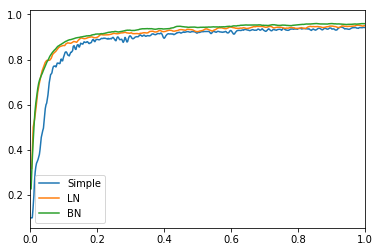

In [37]:
plt.plot(time_stamps_simple, acc_values_simple, label="Simple")
plt.plot(time_stamps_ln, acc_values_ln, label='LN')
plt.plot(time_stamps_bn, acc_values_bn, label='BN')
plt.legend()
plt.xlim([0,1])